# Import Packages

In [1]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [2]:
directory = r'../input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Image Size Variations

In [3]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


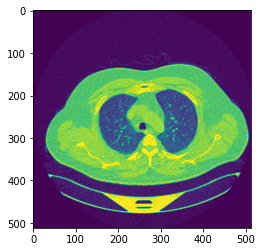

Malignant cases


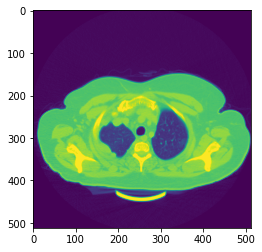

Normal cases


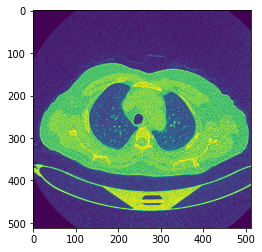

In [4]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# Image Preprocessing and Testing

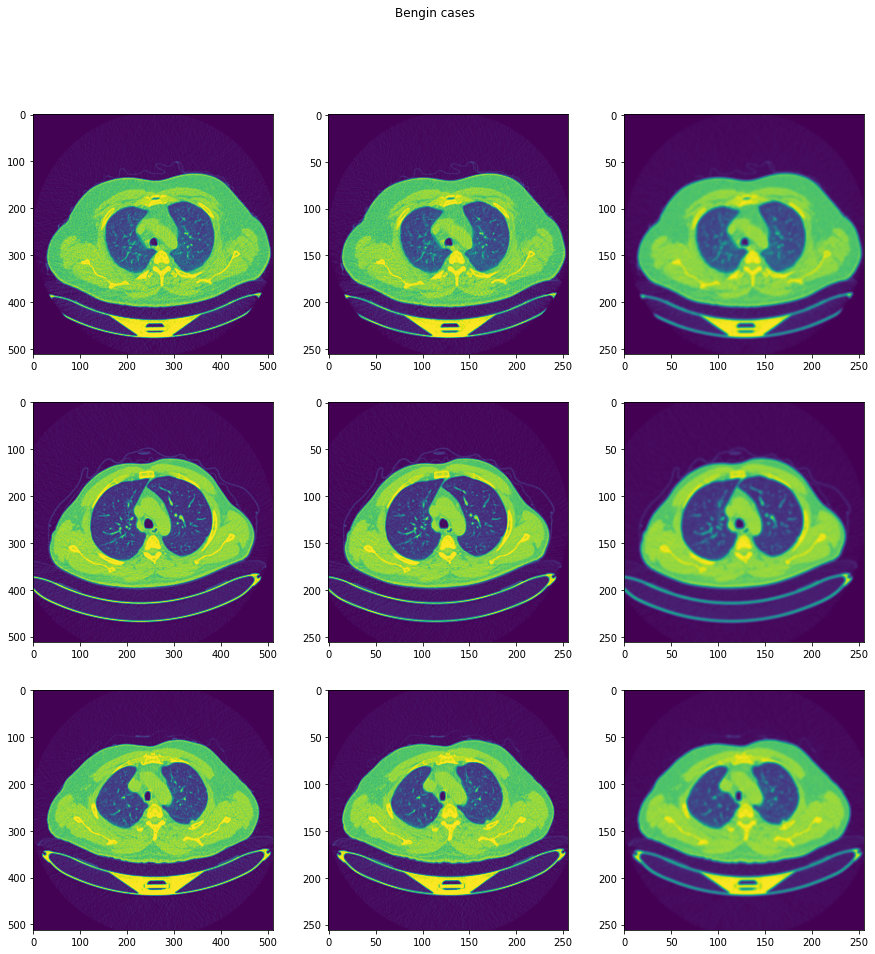

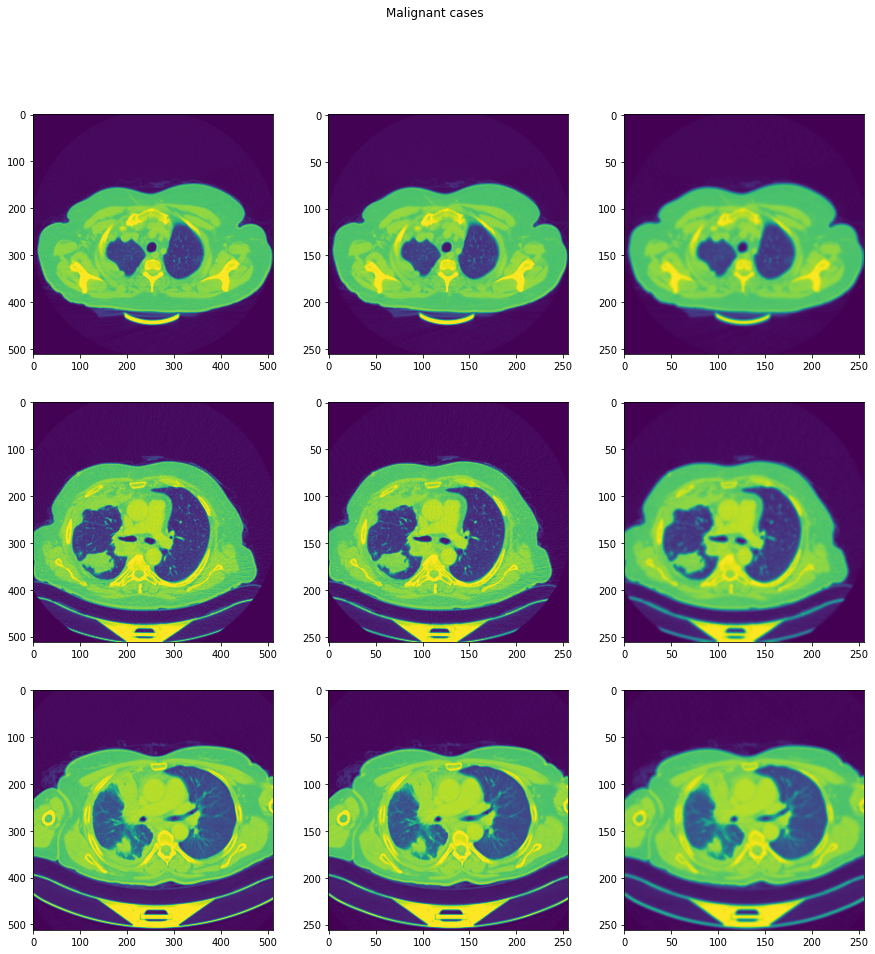

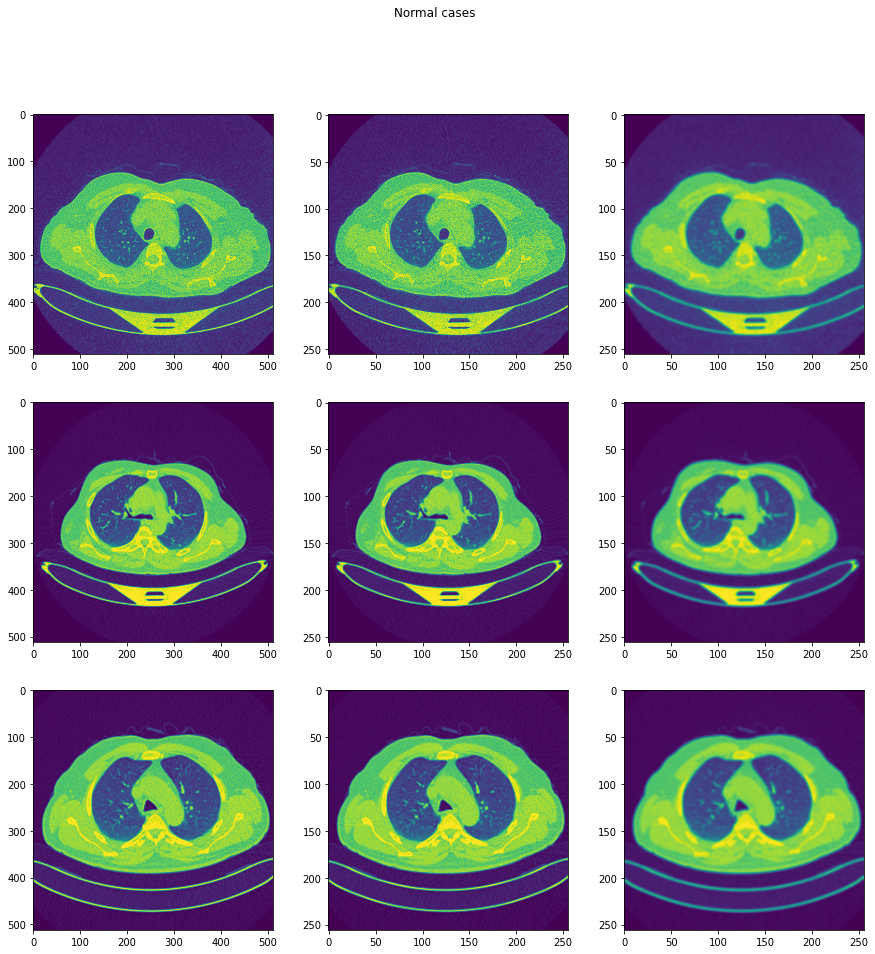

In [5]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

# Preparing Data

In [6]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

In [8]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [9]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [10]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [11]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

In [12]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                3

2021-11-30 18:01:36.778527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 18:01:36.779672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 18:01:36.780384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 18:01:36.781261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

2021-11-30 18:01:40.004451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-30 18:01:41.415383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


158/158 [==============================] - 10s 19ms/step - loss: 0.6241 - accuracy: 0.8246 - val_loss: 0.1110 - val_accuracy: 0.9636
Epoch 2/10
158/158 [==============================] - 2s 16ms/step - loss: 0.0341 - accuracy: 0.9929 - val_loss: 0.0734 - val_accuracy: 0.9818
Epoch 3/10
158/158 [==============================] - 3s 16ms/step - loss: 0.0194 - accuracy: 0.9976 - val_loss: 0.0612 - val_accuracy: 0.9891
Epoch 4/10
158/158 [==============================] - 2s 16ms/step - loss: 7.9046e-04 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9891
Epoch 5/10
158/158 [==============================] - 3s 16ms/step - loss: 9.1531e-04 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9891
Epoch 6/10
158/158 [==============================] - 3s 16ms/step - loss: 1.4046e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9891
Epoch 7/10
158/158 [==============================] - 3s 16ms/step - loss: 1.2933e-04 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 

# Results

In [15]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.99      1.00      1.00       141
           2       0.98      0.99      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.97      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  0 141   0]
 [  0   1 103]]


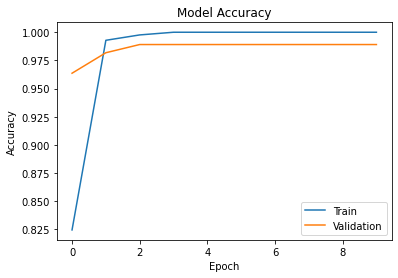

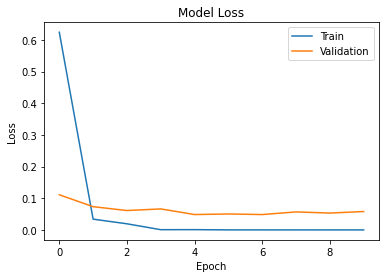

In [16]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model Building with Class Weighted Approach

In [17]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [18]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [20]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
103/103 [==============================] - 2s 21ms/step - loss: 1.0523 - accuracy: 0.7190 - val_loss: 0.2092 - val_accuracy: 0.9273
Epoch 2/10
103/103 [==============================] - 2s 17ms/step - loss: 0.1291 - accuracy: 0.9659 - val_loss: 0.0582 - val_accuracy: 0.9855
Epoch 3/10
103/103 [==============================] - 2s 17ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0535 - val_accuracy: 0.9891
Epoch 4/10
103/103 [==============================] - 2s 17ms/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 0.1668 - val_accuracy: 0.9309
Epoch 5/10
103/103 [==============================] - 2s 17ms/step - loss: 0.0412 - accuracy: 0.9903 - val_loss: 0.0635 - val_accuracy: 0.9891
Epoch 6/10
103/103 [==============================] - 2s 17ms/step - loss: 0.0337 - accuracy: 0.9927 - val_loss: 0.0938 - val_accuracy: 0.9927
Epoch 7/10
103/103 [==============================] - 2s 17ms/step - loss: 0.0306 - accuracy: 0.9976 - val_loss: 0.0455 - val_accuracy: 0.9891

# Results

In [21]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      1.00      1.00       141
           2       0.98      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.98      0.99       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  0 141   0]
 [  0   0 104]]


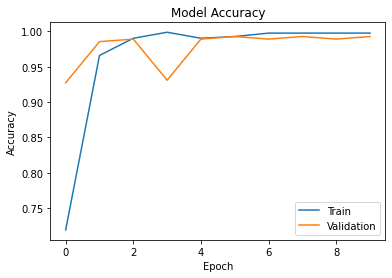

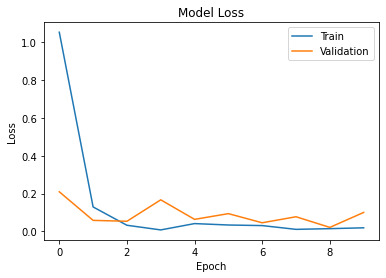

In [22]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Data Augmentation

In [49]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) 
val_datagen = ImageDataGenerator()

In [50]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8) 
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [51]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
activation_5 (Activation)    (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

In [52]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

Epoch 1/5
103/103 [==============================] - 2s 19ms/step - loss: 1.2547 - accuracy: 0.5109 - val_loss: 0.7006 - val_accuracy: 0.7164
Epoch 2/5
103/103 [==============================] - 2s 17ms/step - loss: 0.5844 - accuracy: 0.7676 - val_loss: 0.4634 - val_accuracy: 0.8073
Epoch 3/5
103/103 [==============================] - 2s 17ms/step - loss: 0.3401 - accuracy: 0.8625 - val_loss: 0.3227 - val_accuracy: 0.8655
Epoch 4/5
103/103 [==============================] - 2s 18ms/step - loss: 0.2402 - accuracy: 0.9258 - val_loss: 0.1699 - val_accuracy: 0.9491
Epoch 5/5
103/103 [==============================] - 2s 18ms/step - loss: 0.1968 - accuracy: 0.9477 - val_loss: 0.1099 - val_accuracy: 0.9636


In [54]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.97      0.99      0.98       141
           2       0.95      0.96      0.96       104

    accuracy                           0.96       275
   macro avg       0.96      0.93      0.94       275
weighted avg       0.96      0.96      0.96       275

[[ 25   0   5]
 [  1 140   0]
 [  0   4 100]]
